# Pangeo Billing on AWS

This binder should serve as a tool for looking at billing information for Pangeo's AWS account.

Anyone with admin access (?) should be able to authenticate and use the binder.

In [1]:
import boto3
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 

%matplotlib inline

Try some Boto3

Okay. As long as AWS CLI is configured and you normally have access to the bucket, you can access it here.
- AWS CLI won't be configured automatically in a Binder.
    - Have that as part of the Docker Image, ask users to configure with their keys when they launch
    - Or Find a temporary access method
- On a JupyterHub, some users might already have AWS CLI configured
    - Easier to use this code
    - Data will persist
        - Reduces costs for downloading from S3 many times
        - Data is accessible to anyone who can get into your Hub (security issue)


## Authenticate with Boto3

The method in this notebook works for the following configurations:
- Users who have configured the AWS CLI
 - Boto3 will use the access keys that you put in via 'aws configure'
- Users who are on the us-east-1 pangeo JupyterHub
 - I added a policy to the role the cluster assumes that allows read access to the billing data bucket
 
If neither of these apply, ie. you opened this as a binder, you will need to install and configure the AWS CLI
- See https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-install.html
- Configure via the command 'aws configure'
- Boto3 will then read your access keys as listed above

### Billing Information Buckets

There are two billing information buckets
- copydbr-pangeo
- 783380859522-dlt-utilization

The dlt bucket has more data over more time (from Nov 2018), but Rob declares the following about the copydbr bucket:

"... this is cloudcheckr output which superseded the previous billing bucket: It was adopted by DLT as a better solution; and it has been more reliable."

So, we are using the copydbr bucket by default, but permissions are in place if you want to look at the other one.

In [2]:
# Variables
region = 'us-east-1'
bucket = 'copydbr-pangeo'
file_keys = []

In [3]:
# Spin up base boto3 objects
s3_client = boto3.client('s3', region_name=region)
s3 = boto3.resource('s3', region_name=region)

In [4]:
csv_file_list = s3_client.list_objects(Bucket=bucket)

In [5]:
file_keys = [entry['Key'] for entry in csv_file_list['Contents']]
print("%d file keys" % len(file_keys))
file_keys

2 file keys


['783380859522-aws-billing-detailed-line-items-with-resources-and-tags-2019-10.csv.zip',
 '783380859522-aws-billing-detailed-line-items-with-resources-and-tags-2019-11.csv.zip']

### Download files

Let's grab the csv files themselves

Can for loop the cells below to download everything in file_keys

In [6]:
for key in file_keys:
    download_loc = "/data/" + key
    s3_client.download_file(bucket, key, key)

Unzip the file and watch the command line output

Don't need this right now

for key in file_keys:
    run_cmd_with_output(["unzip", key])

### Move files via command line / subprocess

You don't actually need to unzip,
Pandas read_csv will do it for you!

In [7]:
def run_cmd_with_output(commands):
    print(subprocess.run(commands, capture_output=True
                        ).stdout.decode("utf-8"))

Move data files to a new directory

In [8]:
run_cmd_with_output(["mkdir", "data"])

In [9]:
# Need to run the whole command as one string with shell=True
# Because the wildcard '*' gets interpreted differently otherwise
subprocess.run(["mv *.zip data"], shell=True)
subprocess.run(["mv *.csv data"], shell=True)

CompletedProcess(args=['mv *.csv data'], returncode=1)

Can I circumvent downloading entirely?

Might be able to just load in the data with boto3 into read_csv.

Nope. Too annoying.

### Create the dataframe

In [10]:
df_list = [pd.read_csv("data/" + key, parse_dates=[14, 15]) for key in file_keys]
df = pd.concat(df_list)
df.head()

,InvoiceID,PayerAccountId,LinkedAccountId,RecordType,RecordId,ProductName,RateId,SubscriptionId,PricingPlanId,UsageType,...,UsageEndDate,UsageQuantity,BlendedRate,BlendedCost,UnBlendedRate,UnBlendedCost,ResourceId,user:Name,user:Owner,user:Project
0,329746753.0,465104592472,783380859522,DiscountedUsage,AWS,Amazon Elastic Compute Cloud,NaN,arn:aws:ec2:us-west-2:465104592472:reserved-in...,AmazonEC2,USW2-BoxUsage:m5.large,...,2019-10-01 01:00:00,1.000000e+00,0.096,9.120000e-02,0.096,9.120000e-02,i-05d84710fc674d773,pangeo-esip-core-Node,NaN,NaN
1,329746753.0,465104592472,783380859522,Usage,AWS,Amazon Simple Storage Service,NaN,NaN,AmazonS3,TimedStorage-ByteHrs,...,2019-10-01 01:00:00,8.780000e-07,0.023,1.920000e-08,0.023,1.920000e-08,pangeo-nasa-ops,NaN,NaN,NaN
2,329746753.0,465104592472,783380859522,Tax,AWS,USSalesTax,NaN,NaN,AmazonEC2,USW2-BoxUsage:m5.2xlarge,...,2019-10-16 19:58:36,1.000000e+00,0.000,0.000000e+00,0.000,0.000000e+00,NaN,NaN,NaN,NaN
3,329746753.0,465104592472,783380859522,Usage,AWS,Amazon Elastic Compute Cloud,NaN,NaN,AmazonEC2,EBS:VolumeUsage.gp2,...,2019-10-01 01:00:00,1.344086e-03,0.100,1.276882e-04,0.100,1.276882e-04,vol-04a548d23d54c10ed,kubernetes-dynamic-pvc-df2f564b-571a-11e9-b352...,NaN,NaN
4,329746753.0,465104592472,783380859522,Usage,AWS,Amazon Elastic Compute Cloud,NaN,NaN,AmazonEC2,USW2-DataTransfer-Out-Bytes,...,2019-10-01 01:00:00,1.405841e-04,0.000,0.000000e+00,0.000,0.000000e+00,i-018f284a186ac88e5,amandatan-testmachine,amandatan,ooica


## Computations / Visualizations

In [11]:
total_expenditures = df.BlendedCost.sum()
total_expenditures

12046.012941148496

In [12]:
df.groupby('ProductName').sum()['BlendedCost']

ProductName
AWS CloudTrail                                        0.000000
AWS Glue                                              0.000000
AWS IoT                                               0.001121
AWS Key Management Service                            0.006566
AWS Lambda                                            0.004057
AWS Secrets Manager                                   0.000010
AWS Support (Business)                                0.000000
Amazon DynamoDB                                       0.000000
Amazon EC2 Container Registry (ECR)                   8.596459
Amazon Elastic Compute Cloud                       8177.425750
Amazon Elastic Container Service for Kubernetes    1038.895885
Amazon Elastic File System                         1035.141308
Amazon Glacier                                        0.000002
Amazon Route 53                                       0.190796
Amazon SageMaker                                    135.902850
Amazon Simple Notification Service         

Note: The Custom Charge seen in these cells is DLT Business Support.

In [13]:
df[df['ProductName'] == 'Custom Charge']['ItemDescription'].values[0]

'AWS/DLT Business Support, 10.0000% from $0.00 to $10,000.00'

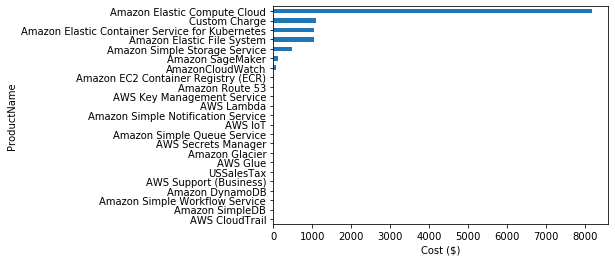

In [14]:
_ = df.groupby('ProductName').sum()['BlendedCost'].sort_values().plot(kind='barh')
_ = plt.xlabel('Cost ($)')

### Analysis Sections

- Daily Costs (done)
- Costs by Cluster
- Monthly Costs (done)
- Costs by User?

In [15]:
df_time_idx = df.set_index("UsageEndDate")
df_time_idx.head()

,InvoiceID,PayerAccountId,LinkedAccountId,RecordType,RecordId,ProductName,RateId,SubscriptionId,PricingPlanId,UsageType,...,UsageStartDate,UsageQuantity,BlendedRate,BlendedCost,UnBlendedRate,UnBlendedCost,ResourceId,user:Name,user:Owner,user:Project
UsageEndDate,,,,,,,,,,,,,,,,,,,,,
2019-10-01 01:00:00,329746753.0,465104592472,783380859522,DiscountedUsage,AWS,Amazon Elastic Compute Cloud,NaN,arn:aws:ec2:us-west-2:465104592472:reserved-in...,AmazonEC2,USW2-BoxUsage:m5.large,...,2019-10-01,1.000000e+00,0.096,9.120000e-02,0.096,9.120000e-02,i-05d84710fc674d773,pangeo-esip-core-Node,NaN,NaN
2019-10-01 01:00:00,329746753.0,465104592472,783380859522,Usage,AWS,Amazon Simple Storage Service,NaN,NaN,AmazonS3,TimedStorage-ByteHrs,...,2019-10-01,8.780000e-07,0.023,1.920000e-08,0.023,1.920000e-08,pangeo-nasa-ops,NaN,NaN,NaN
2019-10-16 19:58:36,329746753.0,465104592472,783380859522,Tax,AWS,USSalesTax,NaN,NaN,AmazonEC2,USW2-BoxUsage:m5.2xlarge,...,2019-10-01,1.000000e+00,0.000,0.000000e+00,0.000,0.000000e+00,NaN,NaN,NaN,NaN
2019-10-01 01:00:00,329746753.0,465104592472,783380859522,Usage,AWS,Amazon Elastic Compute Cloud,NaN,NaN,AmazonEC2,EBS:VolumeUsage.gp2,...,2019-10-01,1.344086e-03,0.100,1.276882e-04,0.100,1.276882e-04,vol-04a548d23d54c10ed,kubernetes-dynamic-pvc-df2f564b-571a-11e9-b352...,NaN,NaN
2019-10-01 01:00:00,329746753.0,465104592472,783380859522,Usage,AWS,Amazon Elastic Compute Cloud,NaN,NaN,AmazonEC2,USW2-DataTransfer-Out-Bytes,...,2019-10-01,1.405841e-04,0.000,0.000000e+00,0.000,0.000000e+00,i-018f284a186ac88e5,amandatan-testmachine,amandatan,ooica


In [16]:
# helper function to process start_time, end_time, and df
def process_start_and_end_time(df, start_time, end_time, cost_col):
    """
    Helper function to use start and end time
    Should function with either, both, or neither of start and end time specified
    """
    data_to_plot = df.resample("D").sum()
    if start_time and end_time:
        data_to_plot = data_to_plot.loc[start_time:end_time, cost_col]
    elif start_time and not end_time:
        data_to_plot = data_to_plot.loc[start_time:, cost_col]
    elif not start_time and end_time:
        data_to_plot = data_to_plot.loc[:end_time, cost_col]
    else:
        data_to_plot = data_to_plot.loc[:, cost_col]
        
    return data_to_plot

In [17]:
def plot_daily_costs(df, start_time=None, end_time=None, cost_col="BlendedCost"):
    """
    Plots a bar graph of daily costs over the specified range
    Can also specify the cost type
    """
    
    # Get the correct data to plot
    data_to_plot = process_start_and_end_time(df, start_time, end_time, cost_col)
    
    # Total Costs and Title / Label Formatting
    cost_total = data_to_plot.sum()
    title = "Daily Costs (Total Cost $%0.2f)" % cost_total
    ylabel = "Daily Costs ($ of %s)" % cost_col

    # Actual Plot
    fig, ax = plt.subplots()

    # Formatting for Dates
    days = mdates.DayLocator()
    months = mdates.MonthLocator()
    month_fmt = mdates.DateFormatter("%B")
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_minor_locator(days)
    ax.xaxis.set_major_formatter(month_fmt)

    # Plot with raw matplotlib
    ax.bar(data_to_plot.index, data_to_plot.values)
    plt.ylabel(ylabel)
    plt.xlabel("Usage End Date")
    plt.title(title)

    return fig

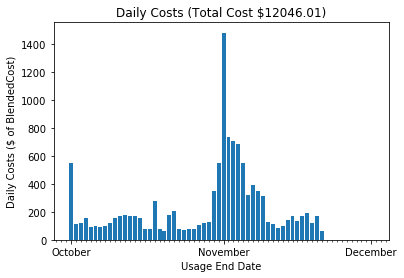

In [18]:
_ = plot_daily_costs(df_time_idx)

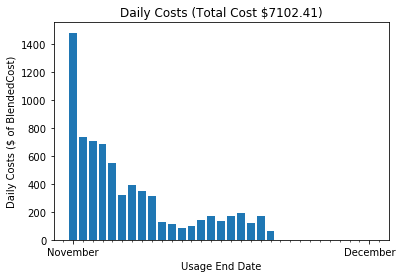

In [19]:
_ = plot_daily_costs(df=df_time_idx, start_time="2019-11-01")

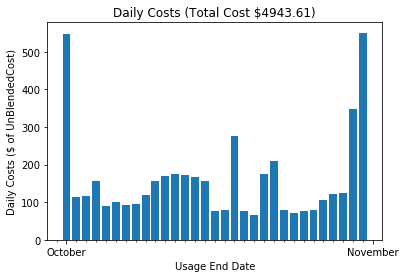

In [20]:
_ = plot_daily_costs(df=df_time_idx, start_time="2019-10-01",
                     end_time="2019-10-31", cost_col="UnBlendedCost")

In [21]:
def plot_monthly_costs(df, start_time=None, end_time=None, cost_col="BlendedCost"):
    """
    Plots a bar graph of month costs over the specified range
    Can also specify the cost column
    """
    
    # Get the correct data to plot
    data_to_plot = process_start_and_end_time(df, start_time, end_time, cost_col)
    
    # Total Nov Costs and Title / Label Formatting
    cost_total = data_to_plot.sum()
    title = "Monthly Costs (Total Cost $%0.2f)" % cost_total
    ylabel = "Monthly Costs ($ of %s)" % cost_col
    
    # Actual Plot
    fig, ax = plt.subplots()

    # Formatting for Dates
    months = mdates.MonthLocator()
    month_fmt = mdates.DateFormatter("%B")
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(month_fmt)

    # Plot with raw matplotlib
    ax.bar(data_to_plot.index, data_to_plot.values)
    plt.ylabel(ylabel)
    plt.xlabel("Usage End Date")
    plt.title(title)

    return fig

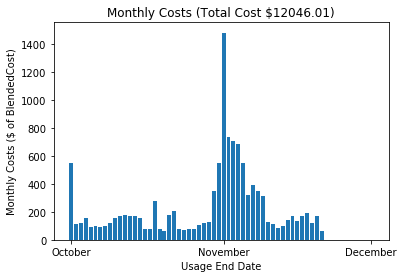

In [22]:
_ = plot_monthly_costs(df_time_idx)